<a href="https://colab.research.google.com/github/spiderpupa/traditional-mongolic-handwritten/blob/main/%EB%AA%BD%EA%B3%A8%EC%96%B4_%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical, Sequence
from keras import layers, models
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir images
%cd ./images

/content/images


In [ ]:
!unzip -qq '/content/drive/MyDrive/mhw/data/images/trainset.zip'
!unzip -qq '/content/drive/MyDrive/mhw/data/images/testset1.zip'
!unzip -qq '/content/drive/MyDrive/mhw/data/images/testset2.zip'

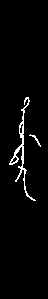

In [ ]:
from google.colab.patches import cv2_imshow
import os
img=cv2.imread('/content/images/t1img1.png')
cv2_imshow(img)

In [ ]:
import scipy.io as sio
import matplotlib
data=sio.loadmat('/content/drive/MyDrive/mhw/data/datasets/Testset_II.mat')
print("\nTestset_I.mat")
print('dtype: ', type(data))
for i in data.keys():
    print('label name: "{name}", item quantity: {length}'.format(name=i, length=len(data[i])))


Testset_I.mat
dtype:  <class 'dict'>
label name: "__header__", item quantity: 76
label name: "__version__", item quantity: 3
label name: "__globals__", item quantity: 0
label name: "test_data3", item quantity: 14085


In [ ]:
def imageFile(n):
    return(data["test_data3"][n][0])

# 패딩용 배열
a = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0 ]])
#저장 경로 설정
def outputPath(n):
    return('/content/drive/MyDrive/mhw/data/images/testset2_images/t2img%d.png' %(n+1))

# 299*48 사이즈에 맞춰 패딩 추가 후 png로 저장
for i in range(len(data["test_data3"])):
    image=(imageFile(i))
    dataReshaped=(image.reshape(1,image.shape[0]*48))
    # 패딩 크기 설정
    margin=(299-image.shape[0])/2
    # 나눈 값이 정수가 아닐 경우 위를 1 짧게, 아래를 1 길게 
    if margin%1==0:
        upper_padding=int(margin)
        lower_padding=int(margin)
    else:
        upper_padding=int(margin-0.5)
        lower_padding=int(margin+0.5)
    
    # 저장용 배열
    img=np.array([])
    upper_margin=np.array([])
    lower_margin=np.array([])
    #패딩 만들기
    for j in range(upper_padding):     
        upper_margin = np.append(a,upper_margin)
    for k in range(lower_padding):
        lower_margin = np.append(a,lower_margin)
    # 패딩 붙이기
    img=np.append(upper_margin,dataReshaped)
    img=np.append(img,lower_margin)
    # 299*48 사이즈로 변형
    img=img.reshape(299,48)
    #png로 저장
    matplotlib.image.imsave(outputPath(i), img, cmap='gray')

### 데이터생성기 클래스

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, labels,img_sizeX, img_sizeY,
    batch_size, num_classes):
     
        # 데이터셋 경로
        self.path = path
        # 데이터 이미지 개별 주소 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.list_IDs = list_IDs
        # 데이터 라벨 리스트 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.labels = labels
        # 가로 크기
        self.img_sizeX = img_sizeX
         # 세로 크기
        self.img_sizeY = img_sizeY
        # 학습 Batch 사이즈
        self.batch_size = batch_size
        # 데이터 라벨의 클래스 수
        self.num_classes = num_classes
        # 전체 데이터 수
        self.indexes = np.arange(len(self.list_IDs))
   
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
            
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_sizeX, self.img_sizeY))
        y = np.zeros((self.batch_size, self.num_classes), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(self.path+ID, cv2.IMREAD_GRAYSCALE)
            X[i, ] = img/255
            y[i, ] = to_categorical(self.labels[i], num_classes=self.num_classes)
        return X, y

### 데이터셋 전처리

#### 라벨 불러오기

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/mhw/data/labels/trainset_label.csv')
t1=pd.read_csv('/content/drive/MyDrive/mhw/data/labels/testset1_label.csv')
t2=pd.read_csv('/content/drive/MyDrive/mhw/data/labels/testset2_label.csv')

set_=pd.concat([t1, t2], axis = 0)
dataset=pd.concat([train, set_], axis = 0)

In [ ]:
labelList=dataset['labels']

In [ ]:
file_list=os.listdir('/content/images')

In [ ]:
for i in range(5000):
    os.rename('t1img%d.png' %(i+1), 'img%d.png' %(i+100001))

In [ ]:
for i in range(14085):
    os.rename('t2img%d.png' %(i+1), 'img%d.png' %(i+150001))

FileNotFoundError: ignored

In [ ]:
# 전체 클래스 수
clss_num=len(labelList.unique())
# 클래스 -> 숫자로 변환 (카테고리 형식의 클래스를 원 핫 인코딩)
labels_dict = dict(zip(labelList.unique(), range(clss_num)))
dataset = dataset.replace({"labels": labels_dict})

In [ ]:
dataset

,image,labels
0,img1.png,0
1,img2.png,1
2,img3.png,2
3,img4.png,3
4,img5.png,4
...,...,...
99995,img99996.png,4995
99996,img99997.png,4996
99997,img99998.png,4997
99998,img99999.png,4998


In [ ]:
testset

,image,labels
0,img1.png,5000
1,img2.png,5001
2,img3.png,5002
3,img4.png,5003
4,img5.png,5004
...,...,...
14080,img14081.png,6730
14081,img14082.png,6730
14082,img14083.png,6730
14083,img14084.png,6730


In [ ]:
# 변수 설정
img_sizeX = 298
img_sizeY = 48
img_ch = 1
num_class = 5000
batch_size = 128

In [ ]:
# 라벨 정보 전처리
train_generator = DataGenerator('/content/images/', train_labels['image'],
                                train_labels['labels'],
                                img_sizeX, img_sizeY,
                                batch_size, 
                                num_class)

test_generator = DataGenerator('/content/images/', test_labels['image'],
                                test_labels['labels'],
                                img_sizeX, img_sizeY,
                                batch_size, 
                                num_class)

print('train_labels: 이미지 개수',len(train_labels['image'].unique()), ', 클래스 개수',len(train_labels['labels'].unique()))
print('test_labels: 이미지 개수',len(test_labels['image'].unique()), ', 클래스 개수',len(test_labels['labels'].unique()))

train_labels: 이미지 개수 60000 , 클래스 개수 5000
test_labels: 이미지 개수 40000 , 클래스 개수 5000


In [ ]:
train_generator = DataGenerator('/content/images/', dataset['image'],
                                dataset['labels'],
                                img_sizeX, img_sizeY,
                                batch_size, 
                                num_class)

In [ ]:
test_labels

,image,labels
0,img75722.png,532
1,img80185.png,4193
2,img19865.png,4791
3,img76700.png,3260
4,img92992.png,1506
...,...,...
39995,img84192.png,1772
39996,img4374.png,2420
39997,img57453.png,2995
39998,img31043.png,410


In [ ]:
del(train_labels)
del(test_labels)

### 모델 설정

In [ ]:
model=models.Sequential()

#인코딩
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(298, 48, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#디코딩
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5000, activation='softmax'))

#모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 296, 46, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 148, 23, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 146, 21, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 73, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 71, 8, 128)        73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 35, 4, 128)      

### 학습 진행

In [ ]:
checkpoint_path = '/content/drive/MyDrive/mhw/Models/cp--{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0,
                                                 save_freq='epoch',
                                                 )  # 5번째 에포크마다 가중치를 저장

In [ ]:
#학습과정 설정
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습 및 평가
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 10, mode = 'auto')
model.fit(train_generator, epochs=50, callbacks = [early_stopping])

Epoch 1/50
782/782 [==============================] - 61s 78ms/step - loss: 4.8426 - accuracy: 0.0154
Epoch 2/50
782/782 [==============================] - 60s 77ms/step - loss: 4.8168 - accuracy: 0.0168
Epoch 3/50
782/782 [==============================] - 63s 80ms/step - loss: 4.8131 - accuracy: 0.0171
Epoch 4/50
782/782 [==============================] - 61s 78ms/step - loss: 4.8079 - accuracy: 0.0179
Epoch 5/50
782/782 [==============================] - 61s 78ms/step - loss: 4.7977 - accuracy: 0.0181
Epoch 6/50
782/782 [==============================] - 61s 79ms/step - loss: 4.7744 - accuracy: 0.0207
Epoch 7/50
782/782 [==============================] - 61s 77ms/step - loss: 4.7208 - accuracy: 0.0252
Epoch 8/50
782/782 [==============================] - 61s 77ms/step - loss: 4.6083 - accuracy: 0.0358
Epoch 9/50
782/782 [==============================] - 61s 78ms/step - loss: 4.4083 - accuracy: 0.0612
Epoch 10/50
782/782 [==============================] - 62s 80ms/step - loss: 4.112

In [ ]:
img=cv2.imread('/content/images/img1.png', cv2.IMREAD_GRAYSCALE)

img=img/255
testdata=img.reshape(1,298,48)
testlabel=pd.DataFrame({'labels':[]})
a=[0]
testlabel['labels']=a


In [ ]:
index_list=[]
for i in range(1,299):
    for j in range(1,49):
        ssss=('%d*%d' %(i,j))
        index_list.append(ssss)
len(index_list)

14304

In [ ]:
testdata.columns=index_list
testdata

,1*1,1*2,1*3,1*4,1*5,1*6,1*7,1*8,1*9,1*10,...,298*39,298*40,298*41,298*42,298*43,298*44,298*45,298*46,298*47,298*48
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
testdata=

40507    img40508.png
72707    img72708.png
90912    img90913.png
28532    img28533.png
13006    img13007.png
             ...     
6265      img6266.png
54886    img54887.png
76820    img76821.png
860        img861.png
15795    img15796.png
Name: image, Length: 60000, dtype: object

In [ ]:
y_train

40507           ᠱᠠᠪᠵᠤ
72707        ᠮᠣᠨᠴᠣᠵᠠᠨ
90912          ᠮᠧᠪᠧᠯᠢ
28532       ᠰᠲ᠋ᠠᠲ᠋ᠦ᠋ᠰ
13006      ᠬᠠᠶᠢᠨᠠᠨᠳᠤᠤ
             ...     
6265         ᠭᠡᠯᠮᠡᠭᠳᠡ
54886    ᠺᠣᠨᠳᠧᠨᠰᠠᠲ᠋ᠣᠷ
76820        ᠠᠮᠤᠵᠢᠭᠤᠯ
860       ᠪᠥᠭᠡᠭᠡᠨᠡᠷᠡᠯ
15795     ᠳᠤᠤᠭᠠᠷᠮᠠᠬᠠᠢ
Name: labels, Length: 60000, dtype: object

In [ ]:
model.evaluate(testdata, testlabel)

ValueError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\n테스트 정확도:', test_acc)
print('\테스트 손실률:', test_loss)

313/313 - 17s - loss: 143.9127 - accuracy: 0.0016 - 17s/epoch - 56ms/step

테스트 정확도: 0.0016473642317578197
\테스트 손실률: 143.91268920898438


In [ ]:
history = model.fit(train_generator, epochs=10, callbacks=[cp_callback])

Epoch 1/10
469/469 [==============================] - 34s 72ms/step - loss: 0.1512 - accuracy: 0.9576
Epoch 2/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1310 - accuracy: 0.9629
Epoch 3/10
469/469 [==============================] - 39s 84ms/step - loss: 0.0963 - accuracy: 0.9718
Epoch 4/10
469/469 [==============================] - 38s 80ms/step - loss: 0.1087 - accuracy: 0.9689
Epoch 5/10
469/469 [==============================] - 42s 90ms/step - loss: 0.2068 - accuracy: 0.9491
Epoch 6/10
469/469 [==============================] - 36s 76ms/step - loss: 0.1419 - accuracy: 0.9621
Epoch 7/10
469/469 [==============================] - 40s 85ms/step - loss: 0.1313 - accuracy: 0.9668
Epoch 8/10
469/469 [==============================] - 39s 83ms/step - loss: 0.1666 - accuracy: 0.9583
Epoch 9/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1166 - accuracy: 0.9693
Epoch 10/10
469/469 [==============================] - 40s 85ms/step - loss: 0.209

In [ ]:
# 결과 저장
model.save('/content/drive/MyDrive/mhw/Models/mhw_model.h5')

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/mhw/Models/t_model.h5')

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo: 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: ignored